In [33]:
from stage1 import *

In [34]:
nframes,natoms,nmols=(0,0,0)

In [35]:
from stage2 import * 

In [36]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [37]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [38]:
cf=condenseframe(testframe)

In [39]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [40]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [41]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:01<00:00, 30.11it/s]

30192


In [42]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [43]:
g = get_graph(cf,1,n_neigh,"cry")

In [44]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [45]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 100
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [46]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:02<00:00, 11081.88it/s]


In [47]:
graphs = graphs_device
total_graphs = len(graphs)


In [48]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [49]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [59]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    closses=0
    flosses=0
    elosses=0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
      
        floss=MSE_loss(decoded_x, data.x)
      
        loss=floss
        loss.backward()
        all_loss_mse += float(loss)
      
        flosses+=float(floss)
        optimizer.step()
        
    return all_loss_mse/len(train_loader)
   

In [60]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [61]:
train_losses = []
test_losses = []
closses=[]
flosses=[]
elosses=[]
if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        # train_loss_mse,closs,floss,eloss = train()
        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        # print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tEdge Loss: {eloss:.4f},\tFace Loss: {floss:.4f}')
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 77.7085
	Test: 	MSE Loss: 58.5305
Epoch: 002
	Train:	MSE Loss: 52.5561
	Test: 	MSE Loss: 43.1757
Epoch: 003
	Train:	MSE Loss: 39.0171
	Test: 	MSE Loss: 33.8898
Epoch: 004
	Train:	MSE Loss: 32.3228
	Test: 	MSE Loss: 29.9664
Epoch: 005
	Train:	MSE Loss: 29.2160
	Test: 	MSE Loss: 28.5097
Epoch: 006
	Train:	MSE Loss: 27.8404
	Test: 	MSE Loss: 27.0550
Epoch: 007
	Train:	MSE Loss: 27.0736
	Test: 	MSE Loss: 25.9342
Epoch: 008
	Train:	MSE Loss: 24.3861
	Test: 	MSE Loss: 23.3917
Epoch: 009
	Train:	MSE Loss: 21.5921
	Test: 	MSE Loss: 20.5882
Epoch: 010
	Train:	MSE Loss: 20.6010
	Test: 	MSE Loss: 19.5630
Epoch: 011
	Train:	MSE Loss: 20.2467
	Test: 	MSE Loss: 19.2664
Epoch: 012
	Train:	MSE Loss: 20.0152
	Test: 	MSE Loss: 20.2893
Epoch: 013
	Train:	MSE Loss: 19.7564
	Test: 	MSE Loss: 19.6691
Epoch: 014
	Train:	MSE Loss: 19.4933
	Test: 	MSE Loss: 19.1143
Epoch: 015
	Train:	MSE Loss: 19.0744
	Test: 	MSE Loss: 19.7121
Epoch: 016
	Train:	MSE Loss: 18.6285
	Test: 	MSE Loss: 

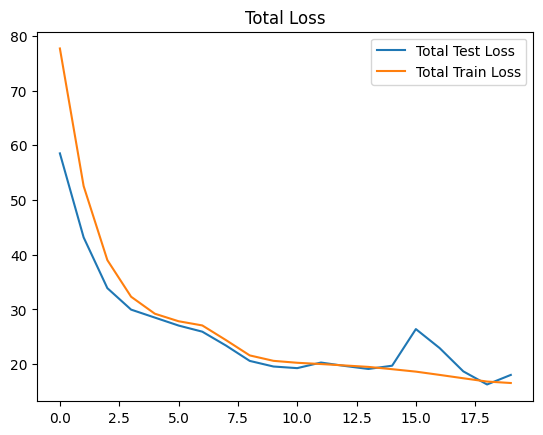

In [62]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

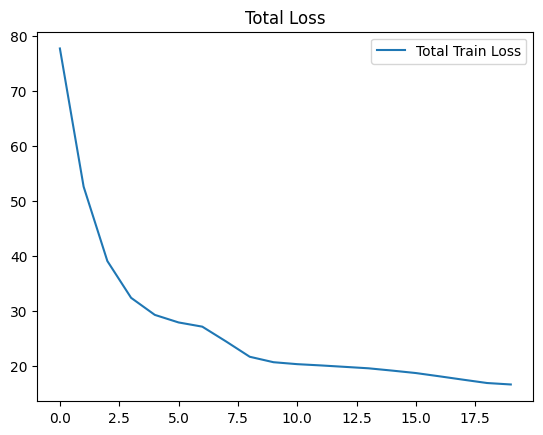

In [63]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

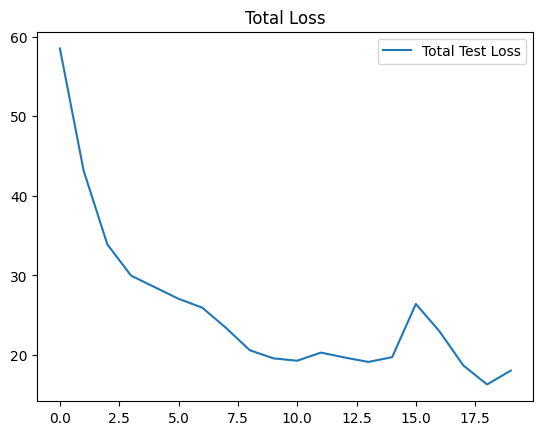

In [64]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [65]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 18.34688427509225


In [66]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [67]:
decoded_feature[0][heavy_indices]

tensor([[ 990.0217, -119.6807, -197.3707,   12.5980,    9.2238,    7.5213],
        [ 989.1991, -120.0667, -197.9889,   13.3116,   14.4436,    9.5364],
        [ 989.2005, -120.0663, -197.9883,   13.3093,   14.4320,    9.5295],
        [ 989.1974, -120.0672, -197.9896,   13.3144,   14.4579,    9.5448],
        [ 989.1980, -120.0670, -197.9894,   13.3134,   14.4526,    9.5417],
        [ 989.1975, -120.0671, -197.9896,   13.3142,   14.4569,    9.5442],
        [ 989.1942, -120.0681, -197.9910,   13.3197,   14.4852,    9.5609],
        [ 989.1973, -120.0672, -197.9897,   13.3146,   14.4592,    9.5456],
        [ 989.1981, -120.0670, -197.9893,   13.3132,   14.4521,    9.5414],
        [ 989.1993, -120.0666, -197.9889,   13.3113,   14.4422,    9.5355],
        [ 989.1959, -120.0676, -197.9903,   13.3170,   14.4712,    9.5526],
        [ 989.1958, -120.0676, -197.9903,   13.3171,   14.4717,    9.5529],
        [ 989.1931, -120.0684, -197.9914,   13.3215,   14.4940,    9.5661],
        [ 98

In [68]:
input_feature[0][heavy_indices]

tensor([[ 988.0850, -119.4721, -197.0187,   24.4200,   11.5275,   13.8225],
        [ 988.7673, -119.7147, -197.2453,   25.7450,   13.9225,   13.4550],
        [ 988.9853, -119.5065, -197.3236,   23.7725,   12.2350,   16.4475],
        [ 987.8770, -119.4200, -196.9512,   21.6250,   11.4075,   14.0800],
        [ 988.5903, -119.7192, -197.1529,   25.6000,    9.0975,   14.8050],
        [ 988.7753, -119.7140, -197.1867,   23.0600,   14.6850,   12.7525],
        [ 988.1803, -119.5604, -197.2062,   25.3975,    8.5975,   11.9700],
        [ 989.2262, -119.5534, -197.1991,   22.8500,   14.3825,   15.4075],
        [ 986.8793, -119.4163, -196.9543,   21.5150,   12.5800,   11.6900],
        [ 988.3565, -119.4749, -197.1041,   21.4800,    9.0200,   15.7150],
        [ 990.6825, -119.9033, -197.5767,   22.6700,   10.2925,   10.0375],
        [ 989.0146, -119.5076, -197.2910,   24.6525,   11.9550,    9.0150],
        [ 989.0651, -119.7558, -197.2872,   24.4350,    6.5900,   13.8075],
        [ 98

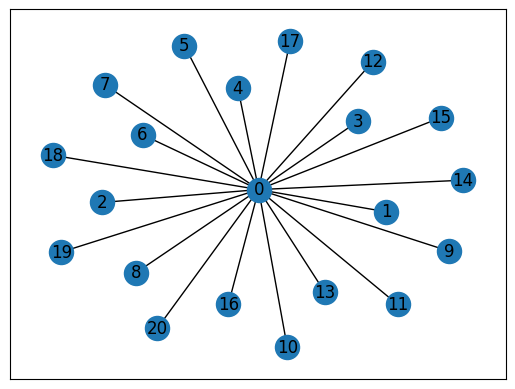

In [69]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [70]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def tryshape():

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        # chamfer_distance needs shaped N P D
        # N is number of points
        # P is number of points to compare to
        # D is dimension of each point
        # where N is the number of points in the pointcloud = 4*number of atoms
        # P is the number of points to compare to = 4*number of atoms
        # D is the dimension of each point = 3
        # reshape decoded_x
        print(data.x.shape)
        # print(decoded_x.shape) - [672,6]
    return 1
    # return all_loss_mse/len(train_loader),closses/len(train_loader),flosses/len(train_loader),elosses/len(train_loader)